In [16]:
import numpy as np
import math
import time

from scipy import linalg as la
from scipy import sparse
from scipy.special import erfc
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import transforms
from matplotlib import rc
from matplotlib import cm
from IPython.display import HTML

from graphic_tools import simple_plotter, matrix_plotter, domain_curve
from heat import get_heat

---
### Analytic solution

$u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$

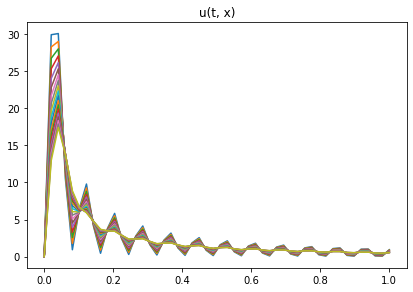

In [160]:
u, _ = get_heat(0.0001, 0.0, 0.5, 0.0, 20, 50)
simple_plotter(u[1:], 'u(t, x)')

---
### Finite element solution

Try a finite element solution implementation

In [24]:
def get_B(X):
    # Mass matrix (Gram). Basis matrix. Positive definite, inversible
    b = np.zeros((X, X))
    d = 1 / (X - 1)
    
    for i in range(X):
        b[i][i] = 4
    
    for i in range(X-1):
        b[i][i+1] = 1
        b[i+1][i] = 1
    
    B = b * d / 6
    
    return B

In [25]:
def get_A(X):
    # Stiffness matrix (Gram).
    a = np.zeros((X, X))
    d = 1 / (X - 1)
    for i in range(X):
        a[i][i] = 2
        
    for i in range(X-1):
        a[i][i+1] = -1
        a[i+1][i] = -1
        
    A = a * (1. / d)
    
    return A

In [26]:
def get_F(X, T):
    d = 1 / (X - 1)
    F = np.zeros((X, T))
    
    t = np.linspace(0, 1, T)
    x = np.linspace(0, 1, X)

    for k in range(T):
        for i in range(1, X):
            F[i][k] = gauss_quadrature(x[i], d, t[k])
            
    return F

In [27]:
def f(x, t):
    # No source function
    return ((np.pi**2) - 1) * np.exp(-t) * np.sin(np.pi * x)

In [28]:
def gauss_quadrature(x, h, t):
    a = x - h/2
    b = x + h/2
    x1 = -np.sqrt(1. / 3.)
    x2 = np.sqrt(1. / 3.)
    
    a1 = ((b - a) * x1 + a + b) / 2
    a2 = ((b - a) * x2 + a + b) / 2
    return (f(a1, t) + f(a2, t)) * (b - a) / 2

In [46]:
def finite_element_heat_1d(t, x, dt, dx):
    T = int(t // dt)
    X = int(x // dx)
    B = get_B(X)  # mass
    A = get_A(X)  # stiffness
    # F = get_F(X, T)
    
    c = np.zeros((X , T))
    # c0 = get_heat(1, x, 1, dx).T
    u0, _ = get_heat(t, 0.0, x, 0.0, T, X)
    c0 = u0.T
    c[:,0] = c0[:, 0]
    
    for t in range(0, T-1):
        # tmp1 = 0 # dt * F[:,t]
        tmp = - dt * np.matmul(A, c[:,t])
        c[:, t+1] = np.linalg.solve(B, tmp) + c[:,t] # tmp + tmp1
    
    return c.T

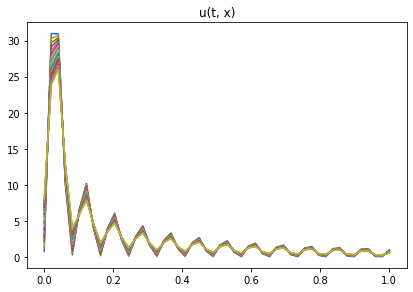

In [50]:
def get_heat_fe(t_max, t_min, x_max, x_min, t_n, x_n):
    dt = (t_max - t_min) / t_n
    B = get_B(x_n)  # mass
    A = get_A(x_n)  # stiffness
    
    c = np.zeros((x_n , t_n))
    u0, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n)
    c0 = u0.T
    c[:, 0] = c0[:, 0]
    
    for t in range(0, t_n - 1):
        tmp = - dt * np.matmul(A, c[:, t])
        c[:, t+1] = np.linalg.solve(B, tmp) + c[:,t]
    
    return c.T

test = get_heat_fe(0.0001, 0.0, 0.5, 0.0, 20, 50)
simple_plotter(test[1:], 'u(t, x)')

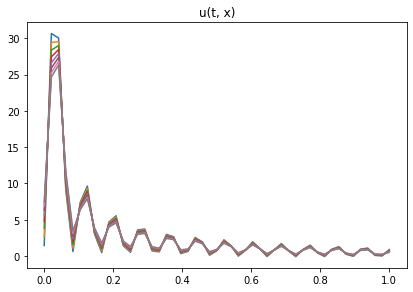

In [47]:
u_fe2 = finite_element_heat_1d(0.0001, 0.5, 0.00001, 0.01)
simple_plotter(u_fe2[1:], 'u(t, x)')

----
### Finite difference discrete solution

Using Dirichlet conditions at 0

In [129]:
def get_heat_fd(t_max, t_min, x_max, x_min, t_n, x_n):
    ua, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n)
    u = np.zeros((t_n, x_n + 1))
    u[0, 1:] = ua[0,:]
    
    for i in range(1, t_n):
        for k in range(1, x_n):
            u[i][k] = (u[i-1][k-1] - 2 * u[i-1][k] + u[i-1][k+1]) * dt / (dx**2) + u[i-1][k]
    
    return u

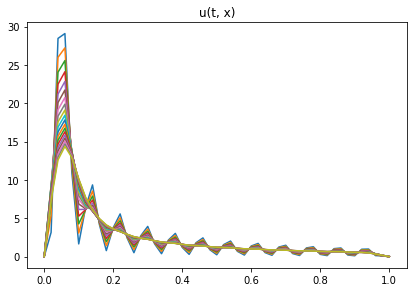

In [130]:
u_fd = get_heat_fd(0.0001, 0.0, 0.5, 0.0, 20, 50)
simple_plotter(u_fd[1:], 'u(t, x)')

---
### Proper orthogonal decomposition (POD)


In [152]:
def pod_beta(U, t_n, x_n, k_min=0, k_max=1):
    # Get covariance matrix
    C = np.matmul(U.T, U) # / X
    
    # Solve eigenproblem
    K, v = la.eigh(C, b=None)
    
    # Sort eigen values and vectors
    indexes = np.argsort(-abs(K))
    K = K[indexes] # eigenvalue
    v = v[:, indexes] # eigenvector = spatial mode
    
    # Compute time coefficient
    A = np.matmul(U, v.T);
    
    u_tilde = np.zeros((t_n, x_n))
    
    for k in range(k_min, k_max, 1):
        Vk = v[k, :]
        Vk = Vk[np.newaxis, :]
        Ak = A[:, k] 
        Ak = Ak[:, np.newaxis]
        u_tilde_k = np.matmul(Ak, Vk)
        u_tilde += u_tilde_k

    return u_tilde

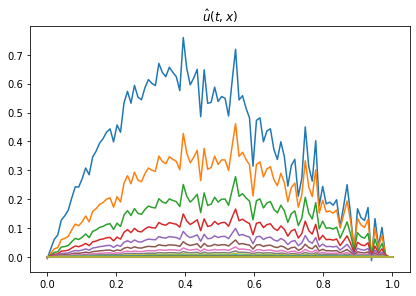

In [175]:
# Obtenir la matrice des snapshots
t_max = 1.0
t_min = 0.0
x_max = 1.0
x_min = 0.0
t_n = 20
x_n = 100

U, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n)
u_pod = pod_beta(U, t_n, x_n, 0, 98) # t_max, t_min, x_max, x_min, 
simple_plotter(u_pod[1:], r'$\hat{u}(t, x)$')

In [15]:
def pod(t, x, dt, dx, k_max=1, theta=1):
    T = int(t // dt)
    X = int(x // dx)
    
    u0 = finite_element_heat_1d(t, x, dt, dx)
    M = get_B(X)
    A = get_A(X)
    F = get_F(X, T)
    B1 = np.dot(M, u0.T)
    B2 = np.transpose(B1)
    Bapp = dt * np.dot(B1, B2)
    K, v = la.eigh(Bapp, M)
    
    En = np.zeros((X, k_max)) 
    for k in range(0, k_max):
        En[:, k] = v[:, X-k-1]
    
    Sn = np.dot(En.T,np.dot(M, En))
    Kn = np.dot(np.dot(En.T, A),En)
    Fbarn = np.dot(En.T, F)
    
    Dtab = np.zeros((k_max, T+1))
    Dold = np.zeros(k_max)
    Dtab[:,0] = Dold
    
    for p in range(0, T):
        B = np.dot((Sn - (1 - theta)*dt*Kn), Dold)
        A = Sn+theta*dt*Kn
        Dnew = la.solve(A, B) 
        Dtab[:,p+1] = Dnew 
        Dold = Dnew
        Utab = np.dot(En, Dtab)
        
    return Utab
    
#     K, s, Vh = la.svd(U)
#     phi = Vh
#     A = np.matmul(U, phi)

In [ ]:
# Obtenir la matrice des snapshots
T = 0.0001
X = 0.5
dt = 0.00001
dx = 0.01

u2 = pod(T, X, dt, dx)
simple_plotter(u2, r'$\hat{u}(t, x)$')

---
### Eigenvalue problem

In [ ]:
def generate_eigenproblem(L):
    # Set value of K with consideration of border
    def set_value(K, i, j, val):
        if (i >= 0 and i < K.shape[0] and j >= 0 and j < K.shape[1]):
            K[i, j] = val
    
    K = np.zeros((L, L), np.float64)
    np.fill_diagonal(K, -2)
    set_value(K, 0, 1, 1)
    set_value(K, L-1, L-2, 1)
    
    for i in range(1, L-1):
        set_value(K, i, i - 1, 1)
        set_value(K, i, i + 1, 1)
    
    return K

In [ ]:
def solve_eigenproblem(L, h):
    """
    Solve eigenproblem using a dense matrix
    :param N: domain size
    :param L: domain side length
    :param shape: membrane shape. 0 = square, 1 = rectangle, 2 = circle
    """
    M = generate_eigenproblem(L)
    start = time.time()
    w, v = la.eigh(M, b=None)
    K = w / (h**2)
    return K, v

In [ ]:
# M = generate_eigenproblem(10, 0.1)
# matrix_plotter(M)
L = 100
h = 0.1
K, v = solve_eigenproblem(L, h)
print(K.shape)
print(v.shape)
indexes = np.argsort(abs(K))
K = K[indexes]
v = v[:, indexes]

domain_curve(K[0], v[0,:], L)
domain_curve(K[1], v[1,:], L)
domain_curve(K[2], v[2,:], L)